# Note 3: Considering Experimental Factors in Data Splitting

## 0. Overview

We have introduced how critical a proper data splitting is in model validation. However, both notes split the data randomly without considering any experimental factors. In this note, we will dive into the details of how the splitting methods can influence our conclusions during model validation.

In [1]:
import numpy as np
import pandas as pd
from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns

# local imports
from note03 import sim_bw, vis_bw, merge_train_test

## 1. Data Simulation

To help us understand the problem, we will use a simulated dataset with a linear mixed model.

- The data records monthly body weight measurements of 30 cows over 24 months. The 30 cows were offsprints of 3 sires (10 cows per sire).

- The simulated body weight is controlled by four fixed effects: `month`, and three arbitrary predictors `X1`, `X2`, and `X3`, and one random effect `sire`.

- Additionally, there is an interaction between `month` and `sire`, which means every sire has a different growth rate over time.

In R library `lmer`, the expression is

```R
Body weight ~ Month + X1 + X2 + X3 + (1 + Month | Sire)
```

In linear algebra, we can write the same equation as follows:

$$
\mathbf{y} = \mathbf{X}\boldsymbol{\beta} + \mathbf{Z}\mathbf{u} + \boldsymbol{\epsilon} 
$$

$$
\mathbf{X}=\left[\begin{array}{c}
1 \\
x_{m} \\
x_{1} \\
x_{2} \\
x_{3}
\end{array}\right]^T,
\mathbf{\beta}=\left[\begin{array}{c}
\beta_0 \\
\beta_m \\
\beta_{x1} \\
\beta_{x2} \\
\beta_{x3}
\end{array}\right],
\mathbf{Z}=\left[\begin{array}{c}
s_1m_0\\
s_1m_1 \\
s_1m_2 \\
\vdots \\
s_3m_{23}\\
s_3m_{24}\\
\end{array}\right]^T
$$

$$
\mathbf{u} \sim \mathcal{N}(\mathbf{0}, \sigma^{2}_{u}(A_{3\times 3}
 \otimes I_{25}))
$$
$$
\boldsymbol{\epsilon} \sim \mathcal{N}(\mathbf{0}, \sigma^{2}_{e} I_{n})
$$

$$
\mathbf{A}=\left[\begin{array}{ccc}
1 & 0.5 & 0 \\
0.5 & 1 & 0 \\
0 & 0 & 1
\end{array}\right]
$$

where $x_m$, $x_1$, $x_2$, and $x_3$ are the values of `month` (from 1 to 24) and the three $x$ predictors (from 0 to 1) in the incidence matrix $\mathbf{X}$, respectively. And $\mathbf{\beta}$ is the vector of fixed effects. $\mathbf{Z}$ is the incidence matrix of the random effect $\mathbf{u}$, where $s_{i}m_{j}$ (value 0 or 1) is the existence of sire $i$ in month $j$, and $s_{i}m_0$ is the random intercept of sire $i$. The covariance matrix $\mathbf{A}$ is the additive genetic relationship matrix of the three sires. The $\boldsymbol{\epsilon}$ is the vector of residuals, and
$\sigma^{2}_{u}$ and $\sigma^{2}_{e}$ are the variance of the random effect and the residual, respectively.

We have pre-defined the simulation script based on the model above. We can use `sim_bw()` to simulate the data.

--- Simulated Pedigree ---
   id  sire  dam
0   1     0    0
1   2     0    0
2   3     1    2
3   4     1    2
4   5     0    0
--------------------------


,sire,cow,month,x1,x2,x3,bw
0,3,1,1,-0.194542,-0.622348,-1.253336,-43.455107
1,3,1,2,-0.857782,0.364364,-0.739544,367.893135
2,3,1,3,-0.617480,1.723373,1.153645,985.911350
3,3,1,4,0.110882,0.942286,2.501156,1287.825450
4,3,1,5,0.521476,-0.240226,-0.031189,738.253516
...,...,...,...,...,...,...,...
715,5,10,20,-1.610581,-0.166434,0.207407,1868.155221
716,5,10,21,-0.932231,0.033391,2.139773,2097.982359
717,5,10,22,0.256589,0.042998,-0.473739,1747.442052
718,5,10,23,-1.721966,-1.244676,2.203148,2021.863166


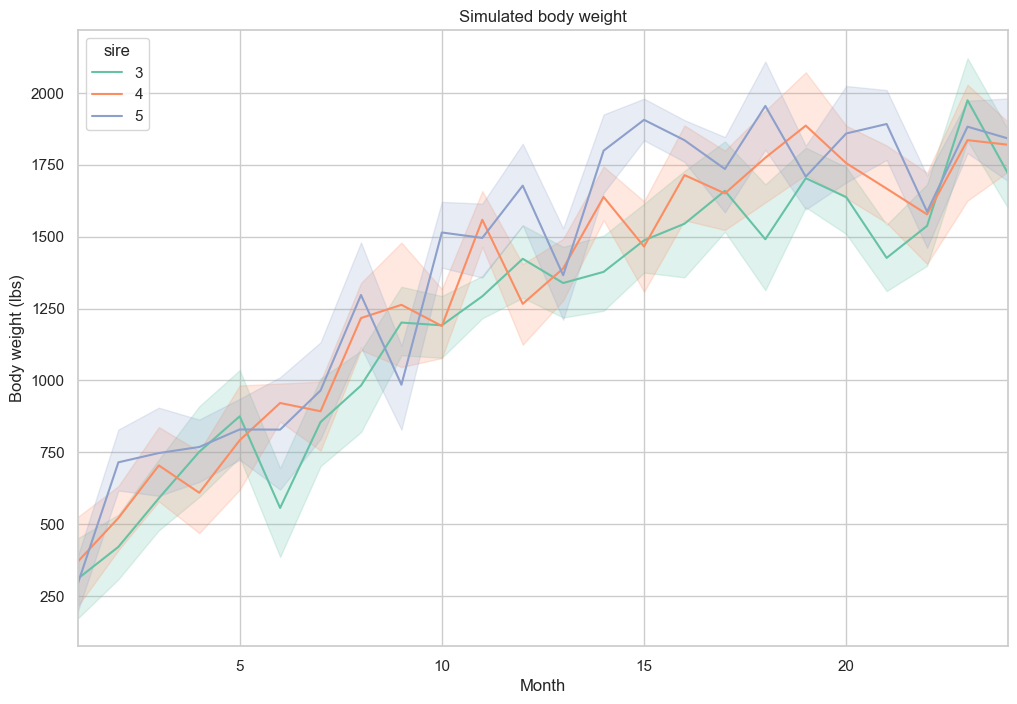

In [2]:
# np.random.seed(0)
data = sim_bw(sdu=100, sde=50)
vis_bw(data)
display(data)

## 2. Splitting Methods

We can consider our dataset as a 3 by 24 matrix, where each row is a sire and each column is a month. Hence, it gives us two ways to split the data: by rows (sires) or by columns (months). Including the previous random splitting, we have three splitting methods in this note:

- Method A: Randonly choose 80% of the data as training set and 20% as testing set.

- Method B: Use the first 16 months as training set and the last 8 months as testing set.

- Method C: Use the first 2 sires as training set and the last sire as testing set.

<img src="res/note03_split.png" width="800"/>

In [3]:
n = len(data)
n_train = int(0.8 * n)
# method A
data_shuffled = data.sample(frac=1)
data_train_A = data_shuffled.iloc[:n_train]
data_test_A = data_shuffled.iloc[n_train:]
# method B
data_train_B = data.query("month <= 16")
data_test_B = data.query("month > 16")
# method C
data_train_C = data.query("sire != 5")
data_test_C = data.query("sire == 5")

## 3. Model Fitting

To demonstrate how the splitting methods influence our model validation, we intentionally use a linear model that only considers the fixed effects:

$$

\mathbf{bw} \sim month + x_1 + x_2 + x_3 + \boldsymbol{\epsilon}


$$

Here we use the `method A` as an example.


In [4]:
# learn coefficients from the training ste
model_ols = smf.ols("bw ~ month + x1 + x2 + x3", data_train_A).fit()
print(model_ols.params)
# predict on the testing set
data_test_A.loc[:, "bw_pre"] = model_ols.predict(data_test_A)
obs = data_test_A["bw"]
pre = data_test_A["bw_pre"]
# evaluation
r = pearsonr(obs, pre)[0].round(3)
mse = mean_squared_error(obs, pre).round(3)
print("correlation: ", r)
print("mse: ", mse)

Intercept    542.014878
month         61.587823
x1            41.813037
x2           104.923307
x3           204.311173
dtype: float64
correlation:  0.931
mse:  33391.458


/var/folders/0k/_fn4_dgn04b2b44_sfhbshzr0000gp/T/ipykernel_26792/1657492891.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_test_A.loc[:, "bw_pre"] = model_ols.predict(data_test_A)


Visualize the result

/Users/niche/Library/CloudStorage/OneDrive-VirginiaTech/_05_Teaching/ADSA_modelvalidation/note03.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_train.loc[:, "predicted_bw"] = data_train["bw"]
/Users/niche/Library/CloudStorage/OneDrive-VirginiaTech/_05_Teaching/ADSA_modelvalidation/note03.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_train.loc[:, "split"] = "train"


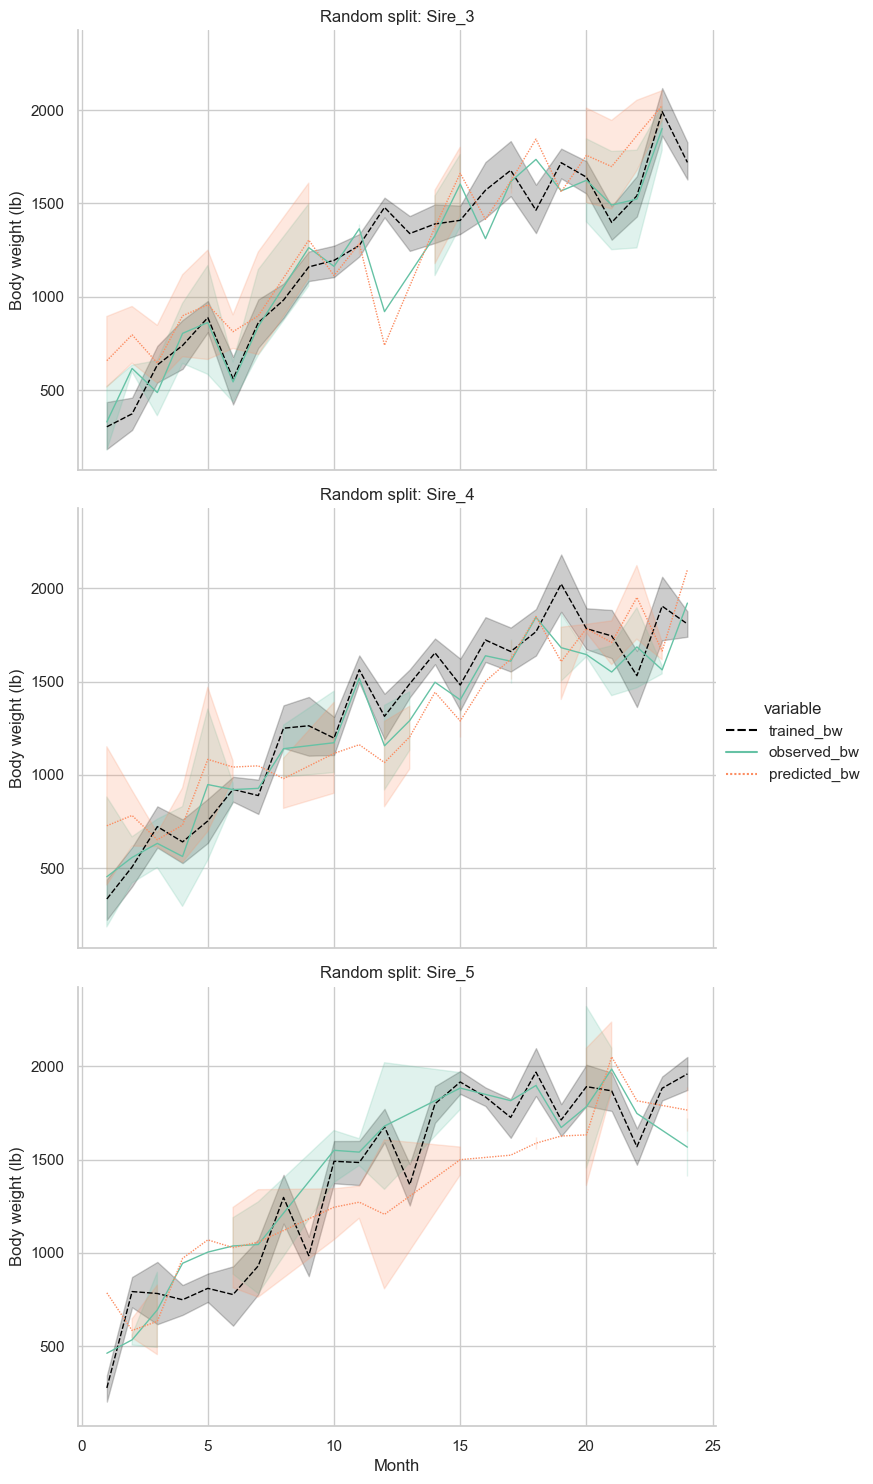

In [5]:
data_all_A = merge_train_test(data_train_A, data_test_A)
plot = sns.relplot(x="month", y="value", hue="variable", style="variable",
            col="sire", col_wrap=1, kind="line",
            hue_order=["trained_bw", "observed_bw", "predicted_bw"],
            palette=["k", "C0", "C1"],
            linewidth=1,
            aspect=1.5,
            data=data_all_A)
plot.set_axis_labels("Month", "Body weight (lb)")
plot.set_titles("Random split: Sire_{col_name}")

Text(0, 0.5, 'Predicted body weight (lbs)')

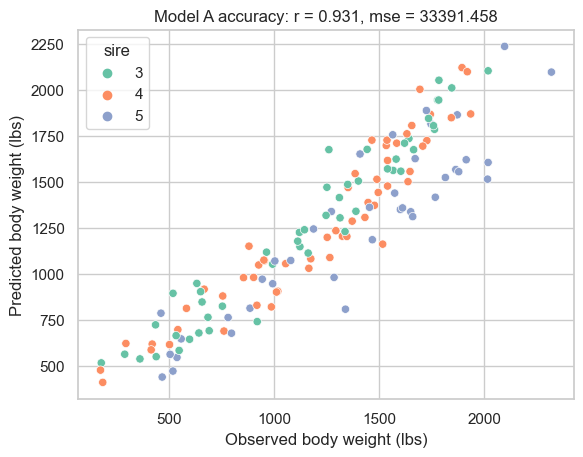

In [6]:
sns.scatterplot(x="bw", y="bw_pre",
                hue="sire", palette=["C0", "C1", "C2"],
                data=data_test_A)
plt.title(f"Model A accuracy: r = {r}, mse = {mse}")
plt.xlabel("Observed body weight (lbs)")
plt.ylabel("Predicted body weight (lbs)")


## 4. Comparison

### 4.1 Functions

Now we can extend the same procedure to the other two splitting methods and compare the results. Let's wrap the code above into a functions

In [7]:
def fit_and_predict(data_train, data_test):
    # learn coefficients from the training ste
    model_ols = smf.ols("bw ~ month + x1 + x2 + x3", data_train).fit()
    # predict on the testing set
    data_test.loc[:, "bw_pre"] = model_ols.predict(data_test)
    # evaluation
    obs = data_test["bw"]
    pre = data_test["bw_pre"]
    # evaluation
    r = pearsonr(obs, pre)[0].round(3)
    mse = mean_squared_error(obs, pre).round(3)
    # print results
    print(f"r = {r}, mse = {mse}")
    # merge
    data_all = merge_train_test(data_train, data_test)
    return data_all, r, mse

def vis_results(data, title):
    plot = sns.relplot(x="month", y="value", hue="variable", style="variable",
            col="sire", col_wrap=1, kind="line", marker="o",
            hue_order=["trained_bw", "observed_bw", "predicted_bw"],
            palette=["k", "C0", "C1"],
            linewidth=1,
            aspect=1.5,
            data=data)
    plot.set_axis_labels("Month", "Body weight (lb)")
    plot.set_titles("%s: Sire_{col_name}" % title)

### 4.2 Method A: Random Splitting

r = 0.931, mse = 33391.458


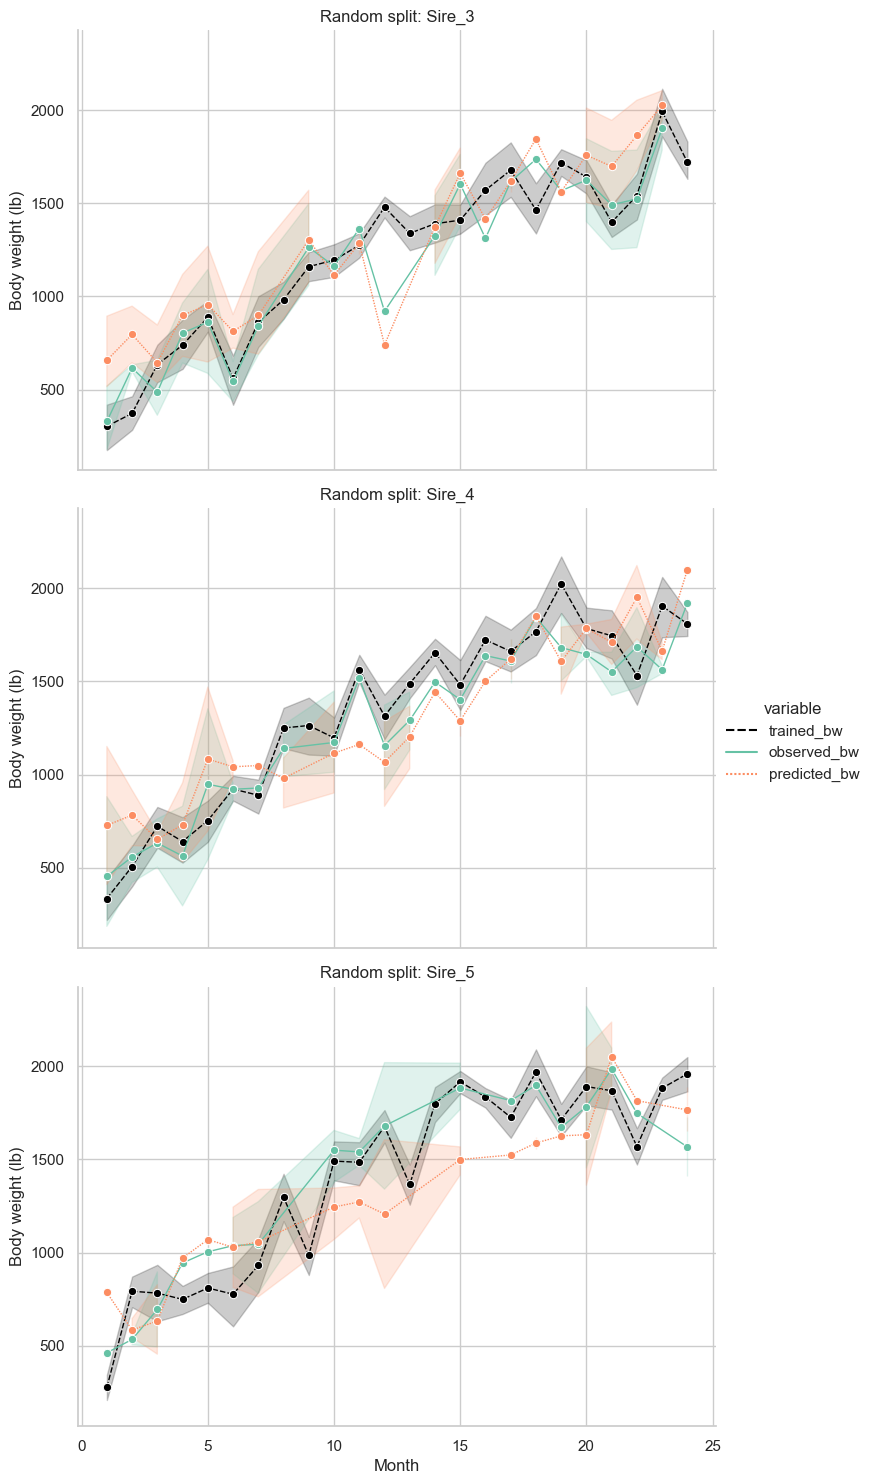

In [8]:
data_A, r_A, mse_A = fit_and_predict(data_train_A, data_test_A)
vis_results(data_A, "Random split")

### 4.3: Method B: Splitting by Month

/var/folders/0k/_fn4_dgn04b2b44_sfhbshzr0000gp/T/ipykernel_26792/2978900096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_test.loc[:, "bw_pre"] = model_ols.predict(data_test)
/Users/niche/Library/CloudStorage/OneDrive-VirginiaTech/_05_Teaching/ADSA_modelvalidation/note03.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_train.loc[:, "predicted_bw"] = data_train["bw"]
/Users/niche/Library/CloudStorage/OneDrive-VirginiaTech/_05_Teaching/ADSA_modelvalidation/note03.py:50: SettingWithCopyWarn

r = 0.741, mse = 209052.006


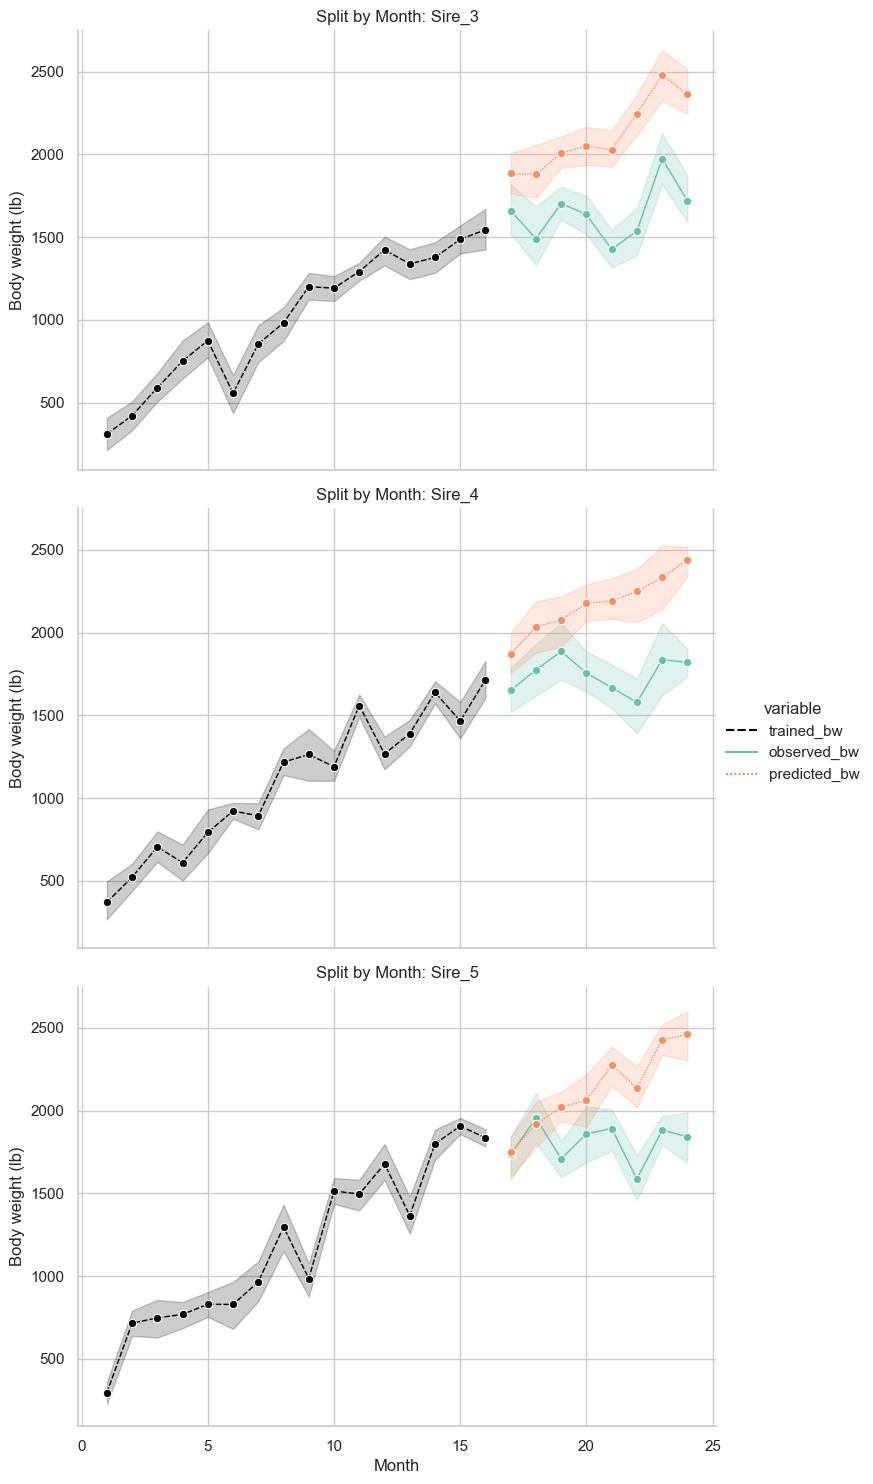

In [9]:
data_B, r_B, mse_B = fit_and_predict(data_train_B, data_test_B)
vis_results(data_B, "Split by Month")

### 4.4 Method C: Splitting by Sires

/var/folders/0k/_fn4_dgn04b2b44_sfhbshzr0000gp/T/ipykernel_26792/2978900096.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_test.loc[:, "bw_pre"] = model_ols.predict(data_test)
/Users/niche/Library/CloudStorage/OneDrive-VirginiaTech/_05_Teaching/ADSA_modelvalidation/note03.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_train.loc[:, "predicted_bw"] = data_train["bw"]
/Users/niche/Library/CloudStorage/OneDrive-VirginiaTech/_05_Teaching/ADSA_modelvalidation/note03.py:50: SettingWithCopyWarn

r = 0.926, mse = 62777.767


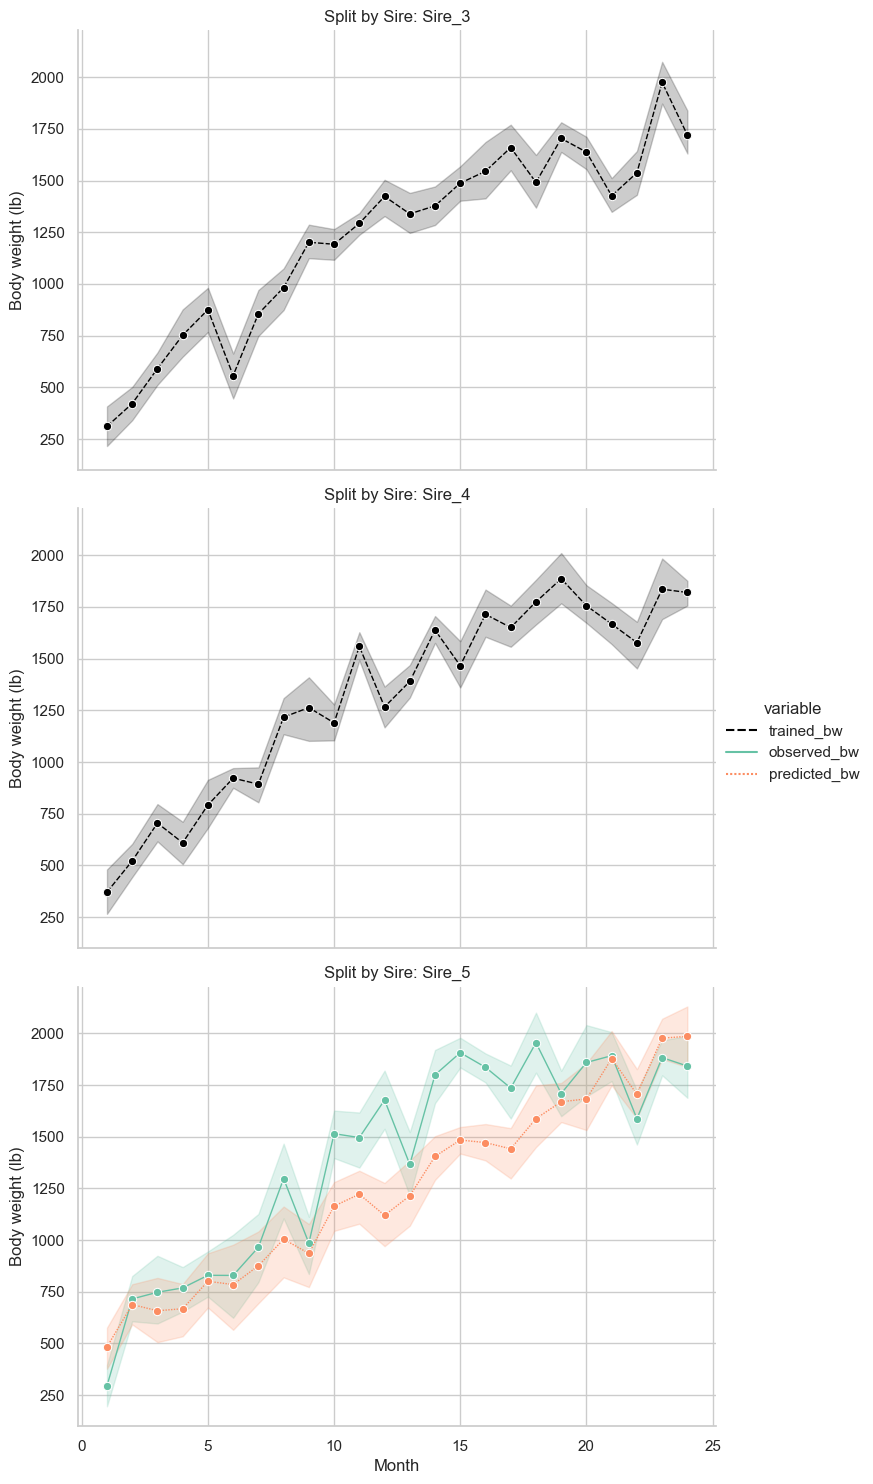

In [10]:
data_C, r_C, mse_C = fit_and_predict(data_train_C, data_test_C)
vis_results(data_C, "Split by Sire")

### 4.5 Performance comparison

We can gather the results from the three methods and compare them.

In [11]:
data_result = pd.DataFrame({"method": ["A: random", "B: by month", "C: by sire"],
                            "r": [r_A, r_B, r_C],
                            "mse": [mse_A, mse_B, mse_C]})
data_result = data_result.melt(id_vars="method", var_name="metric", value_name="value")
display(data_result)

,method,metric,value
0,A: random,r,0.931
1,B: by month,r,0.741
2,C: by sire,r,0.926
3,A: random,mse,33391.458
4,B: by month,mse,209052.006
5,C: by sire,mse,62777.767


Text(0.5, 0, 'Split method')

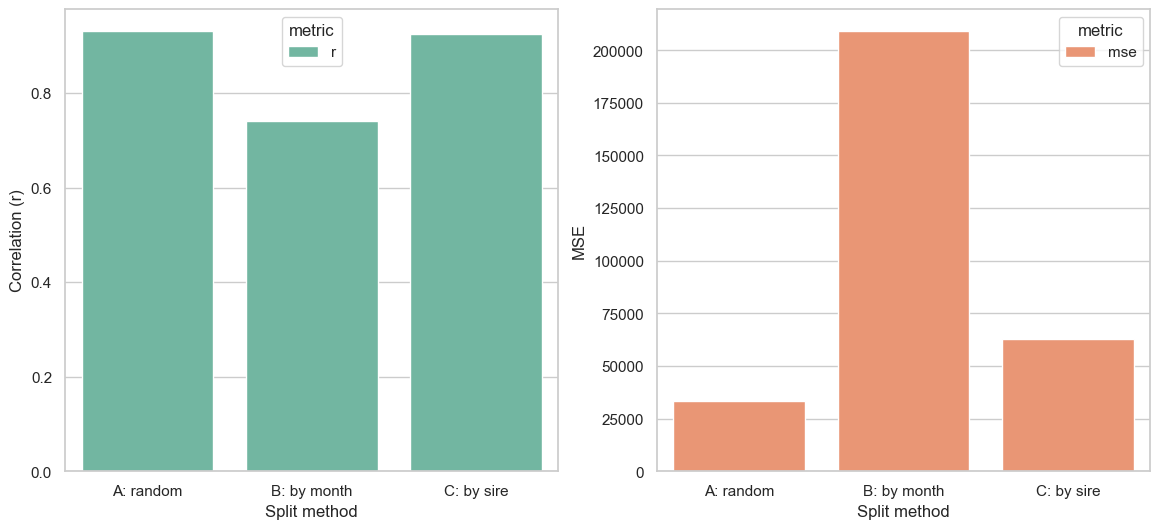

In [12]:
# visualize the results
figure, axes = plt.subplots(figsize=(14, 6), ncols=2, nrows=1)
sns.barplot(x="method", y="value", hue="metric", palette=["C0"],
            data=data_result.query("metric == 'r'"), ax=axes[0])
sns.barplot(x="method", y="value", hue="metric", palette=["C1"],
            data=data_result.query("metric == 'mse'"), ax=axes[1])
axes[0].set_ylabel("Correlation (r)")
axes[1].set_ylabel("MSE")
axes[0].set_xlabel("Split method")
axes[1].set_xlabel("Split method")